# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

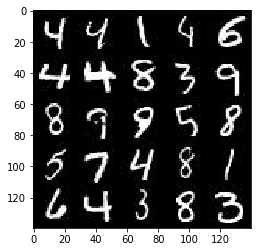

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

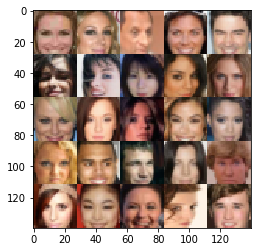

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width,image_height,image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [30]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.08
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        #print(relu1.shape)
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        #print(relu2.shape)
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256        
        #print(relu3.shape)
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*128))
        #print(flat.shape)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.08
    
    with tf.variable_scope('generator',reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.15 * x1, x1)
        # 4x4x256 now
        #print(x1.shape)
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.15 * x2, x2)
        # 8x8x128 now
        #print(x2.shape)
        # Output layer
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.15 * x3, x3)
        #print(x3.shape)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xoutput_dim now
        #print(logits.shape)
        out = tf.tanh(logits)   
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (0.9)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
   
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2.0
                                            
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                    learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                    learn_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 2.3585
Epoch 1/2... Discriminator Loss: 0.4171... Generator Loss: 2.8950
Epoch 1/2... Discriminator Loss: 0.4965... Generator Loss: 2.0854
Epoch 1/2... Discriminator Loss: 0.6442... Generator Loss: 1.5445
Epoch 1/2... Discriminator Loss: 0.6117... Generator Loss: 2.0780
Epoch 1/2... Discriminator Loss: 0.6425... Generator Loss: 1.9672
Epoch 1/2... Discriminator Loss: 0.5869... Generator Loss: 1.8326
Epoch 1/2... Discriminator Loss: 0.5451... Generator Loss: 2.2385
Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 2.5145
Epoch 1/2... Discriminator Loss: 0.6510... Generator Loss: 5.8915


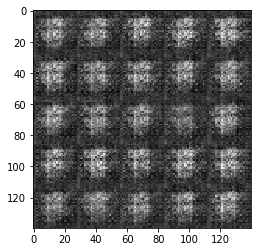

Epoch 1/2... Discriminator Loss: 0.3975... Generator Loss: 3.4942
Epoch 1/2... Discriminator Loss: 0.4043... Generator Loss: 3.9624
Epoch 1/2... Discriminator Loss: 0.3921... Generator Loss: 3.7970
Epoch 1/2... Discriminator Loss: 0.3967... Generator Loss: 3.3845
Epoch 1/2... Discriminator Loss: 0.4332... Generator Loss: 2.7391
Epoch 1/2... Discriminator Loss: 0.3922... Generator Loss: 3.5939
Epoch 1/2... Discriminator Loss: 0.4069... Generator Loss: 3.2766
Epoch 1/2... Discriminator Loss: 0.4043... Generator Loss: 4.0575
Epoch 1/2... Discriminator Loss: 0.4639... Generator Loss: 2.5314
Epoch 1/2... Discriminator Loss: 0.3948... Generator Loss: 3.9895


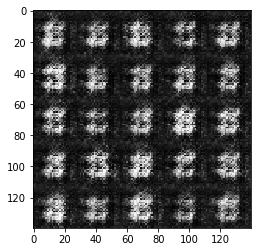

Epoch 1/2... Discriminator Loss: 0.4129... Generator Loss: 3.1707
Epoch 1/2... Discriminator Loss: 0.3910... Generator Loss: 3.5443
Epoch 1/2... Discriminator Loss: 0.4453... Generator Loss: 3.7504
Epoch 1/2... Discriminator Loss: 0.4313... Generator Loss: 2.8126
Epoch 1/2... Discriminator Loss: 0.4686... Generator Loss: 2.5718
Epoch 1/2... Discriminator Loss: 0.3940... Generator Loss: 4.1884
Epoch 1/2... Discriminator Loss: 0.4058... Generator Loss: 3.8495
Epoch 1/2... Discriminator Loss: 0.4711... Generator Loss: 2.3938
Epoch 1/2... Discriminator Loss: 0.3880... Generator Loss: 3.7792
Epoch 1/2... Discriminator Loss: 0.4188... Generator Loss: 3.2359


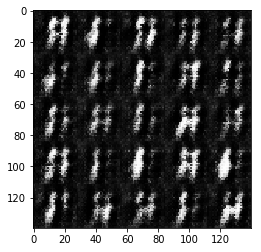

Epoch 1/2... Discriminator Loss: 0.4895... Generator Loss: 4.5383
Epoch 1/2... Discriminator Loss: 0.4384... Generator Loss: 2.8982
Epoch 1/2... Discriminator Loss: 0.4030... Generator Loss: 3.4954
Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 1.2934
Epoch 1/2... Discriminator Loss: 0.6967... Generator Loss: 5.4973
Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 1.5758
Epoch 1/2... Discriminator Loss: 0.4936... Generator Loss: 2.5101
Epoch 1/2... Discriminator Loss: 0.6641... Generator Loss: 1.5490
Epoch 1/2... Discriminator Loss: 0.4562... Generator Loss: 3.2304
Epoch 1/2... Discriminator Loss: 0.4516... Generator Loss: 2.7738


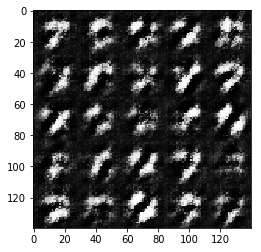

Epoch 1/2... Discriminator Loss: 0.5752... Generator Loss: 4.9380
Epoch 1/2... Discriminator Loss: 0.4111... Generator Loss: 3.8882
Epoch 1/2... Discriminator Loss: 0.4425... Generator Loss: 3.5180
Epoch 1/2... Discriminator Loss: 0.4393... Generator Loss: 3.0454
Epoch 1/2... Discriminator Loss: 0.4490... Generator Loss: 3.5721
Epoch 1/2... Discriminator Loss: 0.5896... Generator Loss: 2.4366
Epoch 1/2... Discriminator Loss: 0.4480... Generator Loss: 2.9634
Epoch 1/2... Discriminator Loss: 0.4889... Generator Loss: 2.3548
Epoch 1/2... Discriminator Loss: 0.5791... Generator Loss: 2.1773
Epoch 1/2... Discriminator Loss: 0.6812... Generator Loss: 1.5636


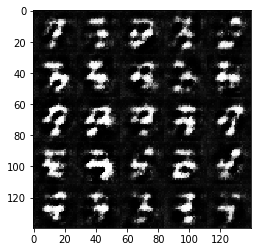

Epoch 1/2... Discriminator Loss: 0.7069... Generator Loss: 4.5068
Epoch 1/2... Discriminator Loss: 0.6059... Generator Loss: 3.3296
Epoch 1/2... Discriminator Loss: 0.4749... Generator Loss: 2.5060
Epoch 1/2... Discriminator Loss: 0.5046... Generator Loss: 2.3151
Epoch 1/2... Discriminator Loss: 0.5030... Generator Loss: 2.2393
Epoch 1/2... Discriminator Loss: 0.4722... Generator Loss: 3.1534
Epoch 1/2... Discriminator Loss: 0.4339... Generator Loss: 3.0177
Epoch 1/2... Discriminator Loss: 0.5063... Generator Loss: 2.7140
Epoch 1/2... Discriminator Loss: 0.4912... Generator Loss: 2.9906
Epoch 1/2... Discriminator Loss: 0.5431... Generator Loss: 2.3120


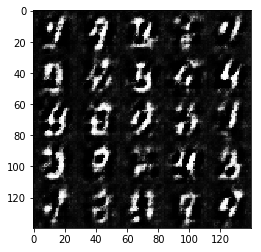

Epoch 1/2... Discriminator Loss: 0.4823... Generator Loss: 3.5733
Epoch 1/2... Discriminator Loss: 0.5271... Generator Loss: 3.7438
Epoch 1/2... Discriminator Loss: 0.4633... Generator Loss: 2.8581
Epoch 1/2... Discriminator Loss: 0.4574... Generator Loss: 2.9536
Epoch 1/2... Discriminator Loss: 0.5495... Generator Loss: 1.9459
Epoch 1/2... Discriminator Loss: 0.4658... Generator Loss: 2.7260
Epoch 1/2... Discriminator Loss: 0.4885... Generator Loss: 2.4471
Epoch 1/2... Discriminator Loss: 0.6455... Generator Loss: 1.7403
Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 2.2949
Epoch 1/2... Discriminator Loss: 0.5452... Generator Loss: 1.9727


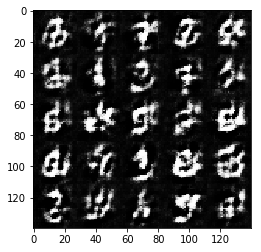

Epoch 1/2... Discriminator Loss: 0.5626... Generator Loss: 2.0873
Epoch 1/2... Discriminator Loss: 0.4447... Generator Loss: 3.7272
Epoch 1/2... Discriminator Loss: 0.5364... Generator Loss: 2.7799
Epoch 1/2... Discriminator Loss: 0.4931... Generator Loss: 2.4450
Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 3.5283
Epoch 1/2... Discriminator Loss: 0.4852... Generator Loss: 2.8160
Epoch 1/2... Discriminator Loss: 0.4848... Generator Loss: 2.6868
Epoch 1/2... Discriminator Loss: 0.4948... Generator Loss: 2.7517
Epoch 1/2... Discriminator Loss: 0.4470... Generator Loss: 3.1712
Epoch 1/2... Discriminator Loss: 0.5301... Generator Loss: 3.6210


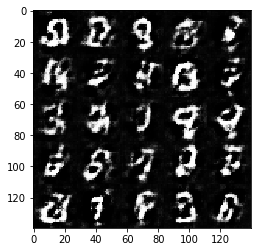

Epoch 1/2... Discriminator Loss: 0.6849... Generator Loss: 1.5037
Epoch 1/2... Discriminator Loss: 0.4887... Generator Loss: 2.8437
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.1992
Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 2.0706
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 2.9718
Epoch 1/2... Discriminator Loss: 0.4543... Generator Loss: 3.1393
Epoch 1/2... Discriminator Loss: 0.5439... Generator Loss: 2.0811
Epoch 1/2... Discriminator Loss: 0.5177... Generator Loss: 2.1889
Epoch 1/2... Discriminator Loss: 0.6490... Generator Loss: 3.2882
Epoch 1/2... Discriminator Loss: 0.5755... Generator Loss: 3.3300


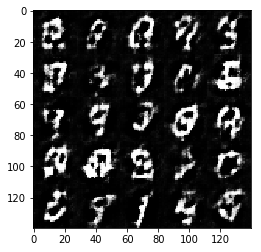

Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 2.3865
Epoch 1/2... Discriminator Loss: 0.7866... Generator Loss: 1.2441
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 0.5669... Generator Loss: 2.9637
Epoch 1/2... Discriminator Loss: 0.7340... Generator Loss: 1.4608
Epoch 1/2... Discriminator Loss: 0.8360... Generator Loss: 1.1213
Epoch 1/2... Discriminator Loss: 0.4936... Generator Loss: 2.3946
Epoch 1/2... Discriminator Loss: 0.6915... Generator Loss: 3.4900
Epoch 1/2... Discriminator Loss: 0.7104... Generator Loss: 3.6220
Epoch 1/2... Discriminator Loss: 0.5206... Generator Loss: 2.3733


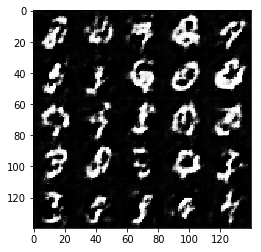

Epoch 1/2... Discriminator Loss: 0.4681... Generator Loss: 2.5757
Epoch 1/2... Discriminator Loss: 0.4353... Generator Loss: 2.8497
Epoch 1/2... Discriminator Loss: 0.5090... Generator Loss: 2.8860
Epoch 1/2... Discriminator Loss: 0.4781... Generator Loss: 2.5104
Epoch 1/2... Discriminator Loss: 0.5126... Generator Loss: 2.7625
Epoch 1/2... Discriminator Loss: 0.7638... Generator Loss: 2.7778
Epoch 1/2... Discriminator Loss: 0.6044... Generator Loss: 1.7749
Epoch 1/2... Discriminator Loss: 0.5897... Generator Loss: 2.3165
Epoch 1/2... Discriminator Loss: 0.4760... Generator Loss: 2.7418
Epoch 1/2... Discriminator Loss: 0.6018... Generator Loss: 3.1298


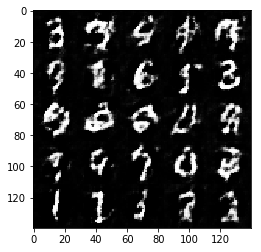

Epoch 1/2... Discriminator Loss: 0.5294... Generator Loss: 2.1080
Epoch 1/2... Discriminator Loss: 0.5829... Generator Loss: 1.8050
Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 2.2077
Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 1.1277
Epoch 1/2... Discriminator Loss: 0.6076... Generator Loss: 1.9553
Epoch 1/2... Discriminator Loss: 0.6490... Generator Loss: 1.5626
Epoch 1/2... Discriminator Loss: 0.6755... Generator Loss: 1.4773
Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 2.1677
Epoch 1/2... Discriminator Loss: 0.5840... Generator Loss: 1.8224
Epoch 1/2... Discriminator Loss: 0.6503... Generator Loss: 2.1555


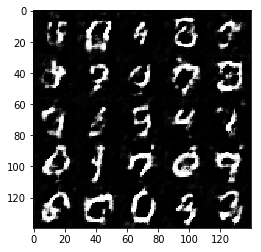

Epoch 1/2... Discriminator Loss: 0.4826... Generator Loss: 2.3894
Epoch 1/2... Discriminator Loss: 0.5077... Generator Loss: 2.3725
Epoch 1/2... Discriminator Loss: 0.5330... Generator Loss: 3.3168
Epoch 1/2... Discriminator Loss: 0.5498... Generator Loss: 1.9323
Epoch 1/2... Discriminator Loss: 0.5174... Generator Loss: 2.2107
Epoch 1/2... Discriminator Loss: 0.7638... Generator Loss: 1.3720
Epoch 1/2... Discriminator Loss: 0.4769... Generator Loss: 2.7562
Epoch 1/2... Discriminator Loss: 0.5242... Generator Loss: 2.3686
Epoch 1/2... Discriminator Loss: 0.4454... Generator Loss: 3.6958
Epoch 1/2... Discriminator Loss: 0.5467... Generator Loss: 2.3268


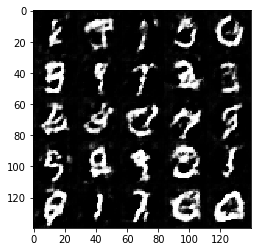

Epoch 1/2... Discriminator Loss: 0.4931... Generator Loss: 2.5101
Epoch 1/2... Discriminator Loss: 0.5024... Generator Loss: 3.1573
Epoch 1/2... Discriminator Loss: 0.5468... Generator Loss: 2.4120
Epoch 1/2... Discriminator Loss: 0.5096... Generator Loss: 2.5544
Epoch 1/2... Discriminator Loss: 0.4920... Generator Loss: 3.1564
Epoch 1/2... Discriminator Loss: 0.6200... Generator Loss: 1.7110
Epoch 1/2... Discriminator Loss: 0.5272... Generator Loss: 2.5767
Epoch 1/2... Discriminator Loss: 0.5179... Generator Loss: 2.3379
Epoch 1/2... Discriminator Loss: 0.5067... Generator Loss: 2.2662
Epoch 1/2... Discriminator Loss: 0.6173... Generator Loss: 3.3076


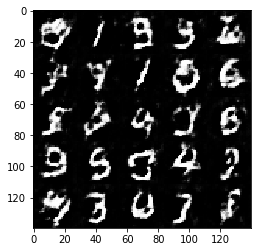

Epoch 1/2... Discriminator Loss: 0.4948... Generator Loss: 2.4883
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 1.1362
Epoch 1/2... Discriminator Loss: 0.7739... Generator Loss: 1.2659
Epoch 1/2... Discriminator Loss: 0.6918... Generator Loss: 1.4193
Epoch 1/2... Discriminator Loss: 0.5899... Generator Loss: 1.9000
Epoch 1/2... Discriminator Loss: 0.5637... Generator Loss: 2.8188
Epoch 1/2... Discriminator Loss: 0.4847... Generator Loss: 2.7758
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 1.0308
Epoch 1/2... Discriminator Loss: 0.5689... Generator Loss: 1.8604
Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 1.0608


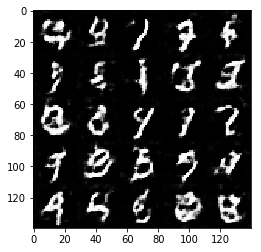

Epoch 1/2... Discriminator Loss: 1.5713... Generator Loss: 4.6184
Epoch 1/2... Discriminator Loss: 0.6565... Generator Loss: 1.5463
Epoch 1/2... Discriminator Loss: 0.5358... Generator Loss: 2.1445
Epoch 1/2... Discriminator Loss: 0.5302... Generator Loss: 2.0553
Epoch 1/2... Discriminator Loss: 0.5825... Generator Loss: 1.8060
Epoch 1/2... Discriminator Loss: 0.5251... Generator Loss: 2.2259
Epoch 1/2... Discriminator Loss: 0.6764... Generator Loss: 2.5395
Epoch 1/2... Discriminator Loss: 0.4644... Generator Loss: 3.2126
Epoch 1/2... Discriminator Loss: 0.6243... Generator Loss: 1.7530
Epoch 1/2... Discriminator Loss: 0.4862... Generator Loss: 2.5527


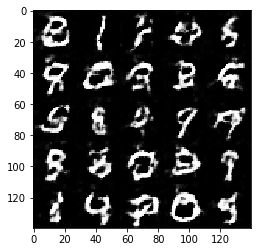

Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 3.3054
Epoch 1/2... Discriminator Loss: 0.7658... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 0.5166... Generator Loss: 2.8676
Epoch 1/2... Discriminator Loss: 0.5966... Generator Loss: 1.8897
Epoch 1/2... Discriminator Loss: 0.5988... Generator Loss: 1.7193
Epoch 1/2... Discriminator Loss: 0.5446... Generator Loss: 2.1381
Epoch 1/2... Discriminator Loss: 0.7502... Generator Loss: 1.4088
Epoch 1/2... Discriminator Loss: 0.5140... Generator Loss: 2.2027
Epoch 1/2... Discriminator Loss: 0.7779... Generator Loss: 1.2992
Epoch 1/2... Discriminator Loss: 0.5432... Generator Loss: 2.8648


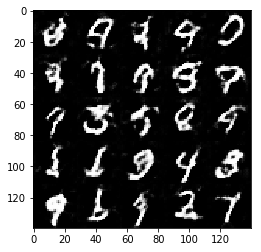

Epoch 1/2... Discriminator Loss: 0.7357... Generator Loss: 1.3421
Epoch 1/2... Discriminator Loss: 0.5824... Generator Loss: 2.0527
Epoch 1/2... Discriminator Loss: 0.4918... Generator Loss: 2.5118
Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 1.6451
Epoch 1/2... Discriminator Loss: 0.6421... Generator Loss: 2.8314
Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 1.9422
Epoch 1/2... Discriminator Loss: 0.5300... Generator Loss: 2.5105
Epoch 1/2... Discriminator Loss: 0.8197... Generator Loss: 1.1391
Epoch 1/2... Discriminator Loss: 0.6744... Generator Loss: 1.4791
Epoch 1/2... Discriminator Loss: 0.6720... Generator Loss: 1.4546


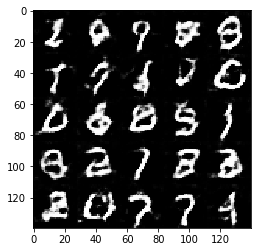

Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 2.9504
Epoch 1/2... Discriminator Loss: 0.5608... Generator Loss: 1.8401
Epoch 1/2... Discriminator Loss: 0.6313... Generator Loss: 1.8292
Epoch 1/2... Discriminator Loss: 0.5443... Generator Loss: 2.0782
Epoch 1/2... Discriminator Loss: 0.6734... Generator Loss: 2.5104
Epoch 1/2... Discriminator Loss: 1.6130... Generator Loss: 0.4543
Epoch 1/2... Discriminator Loss: 0.5128... Generator Loss: 2.7354
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 0.5384... Generator Loss: 2.3185
Epoch 2/2... Discriminator Loss: 0.5702... Generator Loss: 1.9973


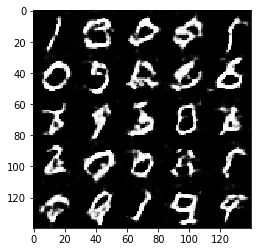

Epoch 2/2... Discriminator Loss: 0.7809... Generator Loss: 2.3250
Epoch 2/2... Discriminator Loss: 0.8411... Generator Loss: 1.2423
Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 3.0896
Epoch 2/2... Discriminator Loss: 0.5964... Generator Loss: 1.8416
Epoch 2/2... Discriminator Loss: 0.5369... Generator Loss: 2.1762
Epoch 2/2... Discriminator Loss: 0.5705... Generator Loss: 1.7956
Epoch 2/2... Discriminator Loss: 1.0733... Generator Loss: 0.8140
Epoch 2/2... Discriminator Loss: 0.7821... Generator Loss: 1.2436
Epoch 2/2... Discriminator Loss: 0.5739... Generator Loss: 1.9992
Epoch 2/2... Discriminator Loss: 0.9718... Generator Loss: 1.0038


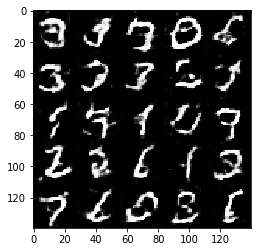

Epoch 2/2... Discriminator Loss: 0.5475... Generator Loss: 2.0103
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 2.6277
Epoch 2/2... Discriminator Loss: 0.5557... Generator Loss: 2.0941
Epoch 2/2... Discriminator Loss: 0.6503... Generator Loss: 1.5086
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 1.8590
Epoch 2/2... Discriminator Loss: 0.4717... Generator Loss: 2.8291
Epoch 2/2... Discriminator Loss: 0.9344... Generator Loss: 3.9040
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 1.7452
Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 1.0515
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 1.5940


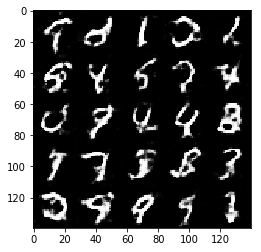

Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.6987
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 1.0669
Epoch 2/2... Discriminator Loss: 0.5382... Generator Loss: 2.2824
Epoch 2/2... Discriminator Loss: 0.5633... Generator Loss: 2.3812
Epoch 2/2... Discriminator Loss: 0.7078... Generator Loss: 1.4622
Epoch 2/2... Discriminator Loss: 0.5294... Generator Loss: 2.3667
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 0.9394
Epoch 2/2... Discriminator Loss: 0.5530... Generator Loss: 1.9169
Epoch 2/2... Discriminator Loss: 0.5892... Generator Loss: 1.8559
Epoch 2/2... Discriminator Loss: 0.6319... Generator Loss: 1.5829


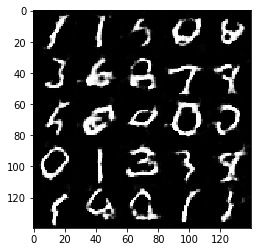

Epoch 2/2... Discriminator Loss: 0.6112... Generator Loss: 1.9051
Epoch 2/2... Discriminator Loss: 0.6150... Generator Loss: 2.5562
Epoch 2/2... Discriminator Loss: 0.5488... Generator Loss: 1.9296
Epoch 2/2... Discriminator Loss: 0.5037... Generator Loss: 2.7566
Epoch 2/2... Discriminator Loss: 0.5540... Generator Loss: 2.0958
Epoch 2/2... Discriminator Loss: 0.4814... Generator Loss: 2.4763
Epoch 2/2... Discriminator Loss: 0.7639... Generator Loss: 1.2574
Epoch 2/2... Discriminator Loss: 0.5018... Generator Loss: 2.3725
Epoch 2/2... Discriminator Loss: 0.4934... Generator Loss: 2.2227
Epoch 2/2... Discriminator Loss: 0.5484... Generator Loss: 1.9048


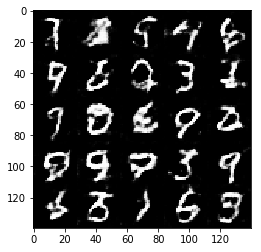

Epoch 2/2... Discriminator Loss: 0.5845... Generator Loss: 1.7969
Epoch 2/2... Discriminator Loss: 0.7372... Generator Loss: 3.6082
Epoch 2/2... Discriminator Loss: 0.5323... Generator Loss: 2.1481
Epoch 2/2... Discriminator Loss: 0.6064... Generator Loss: 1.6901
Epoch 2/2... Discriminator Loss: 0.5958... Generator Loss: 1.7125
Epoch 2/2... Discriminator Loss: 0.5220... Generator Loss: 2.8285
Epoch 2/2... Discriminator Loss: 0.5288... Generator Loss: 2.9187
Epoch 2/2... Discriminator Loss: 0.7550... Generator Loss: 1.3433
Epoch 2/2... Discriminator Loss: 0.9596... Generator Loss: 0.9182
Epoch 2/2... Discriminator Loss: 0.7203... Generator Loss: 1.4055


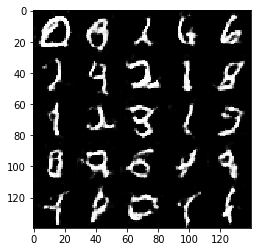

Epoch 2/2... Discriminator Loss: 0.6736... Generator Loss: 1.5076
Epoch 2/2... Discriminator Loss: 0.5401... Generator Loss: 1.9499
Epoch 2/2... Discriminator Loss: 0.6630... Generator Loss: 1.6705
Epoch 2/2... Discriminator Loss: 0.5130... Generator Loss: 2.3834
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 2.3922
Epoch 2/2... Discriminator Loss: 0.6275... Generator Loss: 1.5766
Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 1.7489
Epoch 2/2... Discriminator Loss: 0.5315... Generator Loss: 2.0255
Epoch 2/2... Discriminator Loss: 0.6307... Generator Loss: 1.6033
Epoch 2/2... Discriminator Loss: 0.5353... Generator Loss: 1.9175


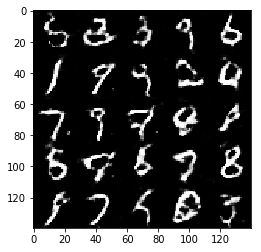

Epoch 2/2... Discriminator Loss: 0.5177... Generator Loss: 2.4425
Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 0.8375
Epoch 2/2... Discriminator Loss: 0.5239... Generator Loss: 2.1627
Epoch 2/2... Discriminator Loss: 0.5703... Generator Loss: 1.9867
Epoch 2/2... Discriminator Loss: 0.6749... Generator Loss: 1.4579
Epoch 2/2... Discriminator Loss: 0.6568... Generator Loss: 1.9576
Epoch 2/2... Discriminator Loss: 0.5667... Generator Loss: 3.2393
Epoch 2/2... Discriminator Loss: 0.4853... Generator Loss: 2.5352
Epoch 2/2... Discriminator Loss: 0.5673... Generator Loss: 2.0178
Epoch 2/2... Discriminator Loss: 0.5479... Generator Loss: 3.1001


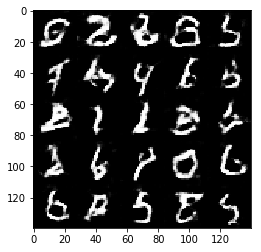

Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 1.0710
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 1.0450
Epoch 2/2... Discriminator Loss: 0.5512... Generator Loss: 2.1743
Epoch 2/2... Discriminator Loss: 0.5407... Generator Loss: 2.1154
Epoch 2/2... Discriminator Loss: 0.5473... Generator Loss: 2.0846
Epoch 2/2... Discriminator Loss: 0.6315... Generator Loss: 1.6296
Epoch 2/2... Discriminator Loss: 0.5840... Generator Loss: 1.7351
Epoch 2/2... Discriminator Loss: 0.5275... Generator Loss: 2.4389
Epoch 2/2... Discriminator Loss: 0.8535... Generator Loss: 1.2109
Epoch 2/2... Discriminator Loss: 0.7634... Generator Loss: 1.2561


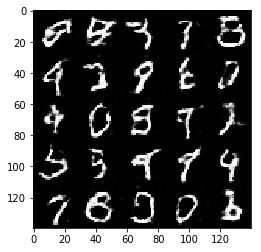

Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 1.8876
Epoch 2/2... Discriminator Loss: 0.6163... Generator Loss: 1.9528
Epoch 2/2... Discriminator Loss: 0.6016... Generator Loss: 1.7106
Epoch 2/2... Discriminator Loss: 0.5180... Generator Loss: 2.1675
Epoch 2/2... Discriminator Loss: 0.5344... Generator Loss: 2.1591
Epoch 2/2... Discriminator Loss: 0.5815... Generator Loss: 1.6982
Epoch 2/2... Discriminator Loss: 0.5841... Generator Loss: 1.9330
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 0.5328... Generator Loss: 2.0196
Epoch 2/2... Discriminator Loss: 0.5793... Generator Loss: 2.0990


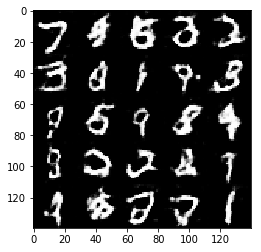

Epoch 2/2... Discriminator Loss: 0.5060... Generator Loss: 2.2336
Epoch 2/2... Discriminator Loss: 0.5150... Generator Loss: 2.1243
Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 1.0416
Epoch 2/2... Discriminator Loss: 0.5151... Generator Loss: 2.8832
Epoch 2/2... Discriminator Loss: 0.4470... Generator Loss: 2.4747
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 4.1217
Epoch 2/2... Discriminator Loss: 0.7043... Generator Loss: 1.5413
Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 1.7940
Epoch 2/2... Discriminator Loss: 0.4742... Generator Loss: 2.3703
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.2781


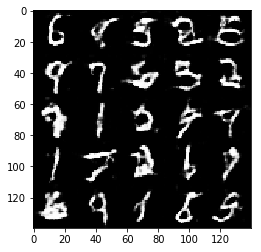

Epoch 2/2... Discriminator Loss: 0.5200... Generator Loss: 2.1442
Epoch 2/2... Discriminator Loss: 0.5133... Generator Loss: 2.1381
Epoch 2/2... Discriminator Loss: 1.0474... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 0.5584... Generator Loss: 1.9118
Epoch 2/2... Discriminator Loss: 0.6639... Generator Loss: 1.4952
Epoch 2/2... Discriminator Loss: 0.6227... Generator Loss: 1.6640
Epoch 2/2... Discriminator Loss: 0.4844... Generator Loss: 2.4109
Epoch 2/2... Discriminator Loss: 0.5207... Generator Loss: 2.0847
Epoch 2/2... Discriminator Loss: 0.4866... Generator Loss: 2.3187
Epoch 2/2... Discriminator Loss: 0.5571... Generator Loss: 1.9641


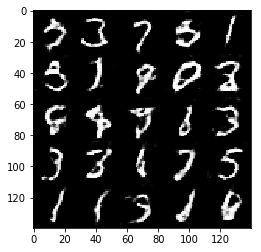

Epoch 2/2... Discriminator Loss: 0.5197... Generator Loss: 2.2270
Epoch 2/2... Discriminator Loss: 0.5307... Generator Loss: 2.5641
Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 1.1063
Epoch 2/2... Discriminator Loss: 0.5244... Generator Loss: 2.2843
Epoch 2/2... Discriminator Loss: 0.4816... Generator Loss: 2.2893
Epoch 2/2... Discriminator Loss: 0.6510... Generator Loss: 1.5023
Epoch 2/2... Discriminator Loss: 0.8493... Generator Loss: 1.0604
Epoch 2/2... Discriminator Loss: 0.5429... Generator Loss: 2.1683
Epoch 2/2... Discriminator Loss: 0.5821... Generator Loss: 1.8528


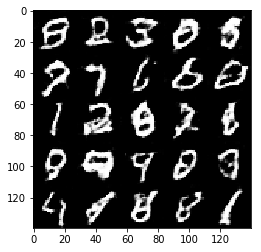

Epoch 2/2... Discriminator Loss: 0.5549... Generator Loss: 2.7681
Epoch 2/2... Discriminator Loss: 2.1368... Generator Loss: 0.3338
Epoch 2/2... Discriminator Loss: 0.4471... Generator Loss: 2.7863
Epoch 2/2... Discriminator Loss: 0.5469... Generator Loss: 2.0406
Epoch 2/2... Discriminator Loss: 0.5274... Generator Loss: 2.2306
Epoch 2/2... Discriminator Loss: 0.5292... Generator Loss: 1.9697
Epoch 2/2... Discriminator Loss: 0.5080... Generator Loss: 2.3989
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 2.2428
Epoch 2/2... Discriminator Loss: 0.5338... Generator Loss: 2.0481
Epoch 2/2... Discriminator Loss: 0.4913... Generator Loss: 2.5348


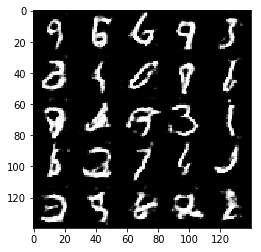

Epoch 2/2... Discriminator Loss: 0.4580... Generator Loss: 2.5991
Epoch 2/2... Discriminator Loss: 0.5533... Generator Loss: 2.8265
Epoch 2/2... Discriminator Loss: 1.4557... Generator Loss: 0.5567
Epoch 2/2... Discriminator Loss: 0.4846... Generator Loss: 2.5118
Epoch 2/2... Discriminator Loss: 0.5029... Generator Loss: 2.4738
Epoch 2/2... Discriminator Loss: 0.5704... Generator Loss: 1.7982
Epoch 2/2... Discriminator Loss: 0.5123... Generator Loss: 2.6567
Epoch 2/2... Discriminator Loss: 0.4981... Generator Loss: 2.3128
Epoch 2/2... Discriminator Loss: 0.6575... Generator Loss: 2.7248
Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 1.4267


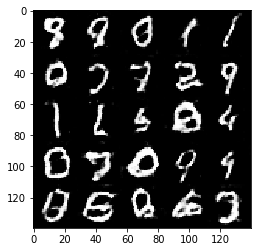

Epoch 2/2... Discriminator Loss: 0.5203... Generator Loss: 2.0947
Epoch 2/2... Discriminator Loss: 0.5839... Generator Loss: 1.7988
Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 0.9509
Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 1.7470
Epoch 2/2... Discriminator Loss: 0.4621... Generator Loss: 2.5143
Epoch 2/2... Discriminator Loss: 0.4442... Generator Loss: 2.9430
Epoch 2/2... Discriminator Loss: 0.4582... Generator Loss: 2.5403
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.2382
Epoch 2/2... Discriminator Loss: 0.5383... Generator Loss: 3.0315
Epoch 2/2... Discriminator Loss: 0.5302... Generator Loss: 2.2611


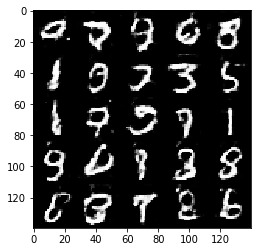

Epoch 2/2... Discriminator Loss: 0.4756... Generator Loss: 2.4729
Epoch 2/2... Discriminator Loss: 0.6981... Generator Loss: 3.4429
Epoch 2/2... Discriminator Loss: 0.7272... Generator Loss: 2.4970
Epoch 2/2... Discriminator Loss: 0.6464... Generator Loss: 1.5191
Epoch 2/2... Discriminator Loss: 0.6751... Generator Loss: 1.4029
Epoch 2/2... Discriminator Loss: 0.5104... Generator Loss: 2.1026
Epoch 2/2... Discriminator Loss: 0.5510... Generator Loss: 1.9194
Epoch 2/2... Discriminator Loss: 0.5806... Generator Loss: 1.8455
Epoch 2/2... Discriminator Loss: 0.5449... Generator Loss: 2.3734
Epoch 2/2... Discriminator Loss: 0.4857... Generator Loss: 2.2317


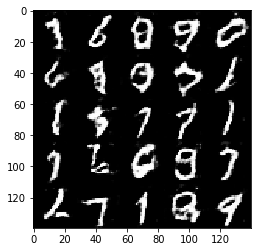

Epoch 2/2... Discriminator Loss: 0.4986... Generator Loss: 2.2326
Epoch 2/2... Discriminator Loss: 0.6633... Generator Loss: 1.4591
Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 1.9831
Epoch 2/2... Discriminator Loss: 0.5197... Generator Loss: 2.1329
Epoch 2/2... Discriminator Loss: 0.6835... Generator Loss: 1.4462
Epoch 2/2... Discriminator Loss: 0.5649... Generator Loss: 1.9463
Epoch 2/2... Discriminator Loss: 0.6557... Generator Loss: 1.4161
Epoch 2/2... Discriminator Loss: 0.5675... Generator Loss: 2.2803
Epoch 2/2... Discriminator Loss: 0.5149... Generator Loss: 2.1816
Epoch 2/2... Discriminator Loss: 0.5916... Generator Loss: 1.7324


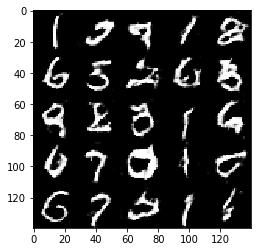

Epoch 2/2... Discriminator Loss: 0.6189... Generator Loss: 1.6975
Epoch 2/2... Discriminator Loss: 0.7083... Generator Loss: 1.3963
Epoch 2/2... Discriminator Loss: 0.5726... Generator Loss: 1.7849
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 3.8994
Epoch 2/2... Discriminator Loss: 0.7050... Generator Loss: 1.3442
Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 1.2226
Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 1.7680
Epoch 2/2... Discriminator Loss: 0.4843... Generator Loss: 2.3603
Epoch 2/2... Discriminator Loss: 0.5236... Generator Loss: 2.1097
Epoch 2/2... Discriminator Loss: 0.5565... Generator Loss: 1.9359


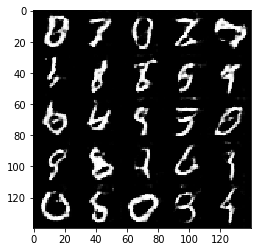

Epoch 2/2... Discriminator Loss: 0.4975... Generator Loss: 2.3327
Epoch 2/2... Discriminator Loss: 0.5660... Generator Loss: 1.9184
Epoch 2/2... Discriminator Loss: 0.4732... Generator Loss: 3.1104
Epoch 2/2... Discriminator Loss: 0.5955... Generator Loss: 1.8044
Epoch 2/2... Discriminator Loss: 0.4638... Generator Loss: 2.4438


In [36]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 2.3957
Epoch 1/1... Discriminator Loss: 0.4525... Generator Loss: 2.7932
Epoch 1/1... Discriminator Loss: 0.4612... Generator Loss: 2.4392
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 2.4978
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 2.4689
Epoch 1/1... Discriminator Loss: 0.4037... Generator Loss: 3.2977
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 3.3297
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 2.3544
Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 1.6970
Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 2.9637


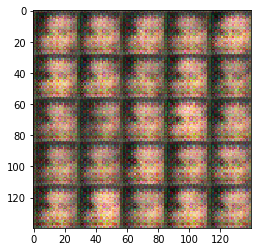

Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 3.2295
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 1.9384
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 1.7023
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 3.9869
Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 4.0103
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 2.7029
Epoch 1/1... Discriminator Loss: 0.5695... Generator Loss: 1.9897
Epoch 1/1... Discriminator Loss: 0.4721... Generator Loss: 2.7729
Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 2.5349
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 1.5487


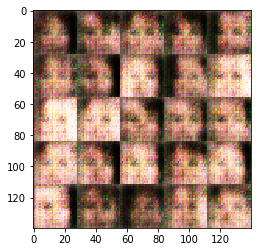

Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 2.6233
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.3054
Epoch 1/1... Discriminator Loss: 0.6916... Generator Loss: 1.5183
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 2.6592
Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 2.9951
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 3.7042
Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 3.1324
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 5.0713
Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 2.6154


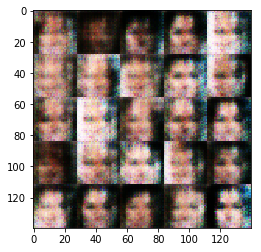

Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 2.1913
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 1.4220
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 3.1563
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 2.4205
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 2.8668
Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 2.1125
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 2.7583
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 1.5285
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 1.9462


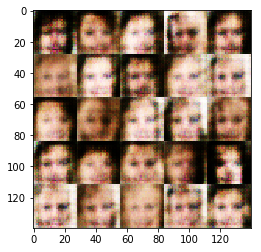

Epoch 1/1... Discriminator Loss: 0.7617... Generator Loss: 1.3144
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 1.8325
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 2.9323
Epoch 1/1... Discriminator Loss: 0.6880... Generator Loss: 1.5925
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 2.6241
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 1.7676
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 1.9053
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 1.4467
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.7389


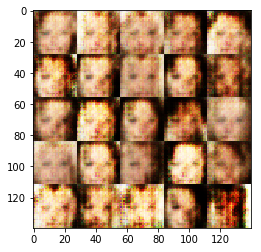

Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 2.4403
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 2.3712
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 2.4639
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 3.1393
Epoch 1/1... Discriminator Loss: 0.6272... Generator Loss: 1.8926
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 3.0514
Epoch 1/1... Discriminator Loss: 1.6473... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 0.6461... Generator Loss: 2.0004
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 2.2589


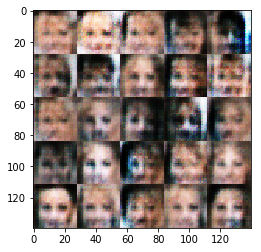

Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 2.9899
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 2.1149
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 4.2616
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 0.6747... Generator Loss: 2.1903
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 1.8876
Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 3.7113
Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 2.2486
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 1.7008
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 1.6733


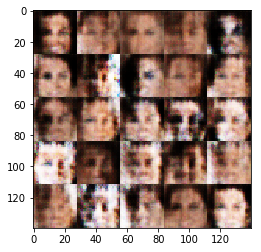

Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 1.7872
Epoch 1/1... Discriminator Loss: 0.5833... Generator Loss: 2.3255
Epoch 1/1... Discriminator Loss: 0.6916... Generator Loss: 1.5111
Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 1.9496
Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 2.1027
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.8288
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 2.0704
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 1.3353
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.4771
Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 1.3646


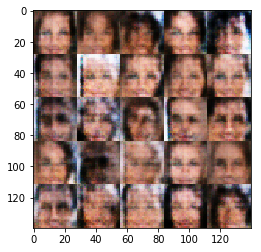

Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 1.5999
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 2.0380
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.6687
Epoch 1/1... Discriminator Loss: 0.6497... Generator Loss: 2.0326
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 1.8233
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 2.0737
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.6641


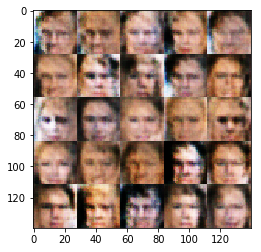

Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.5690
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 1.4991
Epoch 1/1... Discriminator Loss: 0.7266... Generator Loss: 2.0209
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 2.0569
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 1.6065
Epoch 1/1... Discriminator Loss: 0.7080... Generator Loss: 1.8758
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 1.8032
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 2.4940


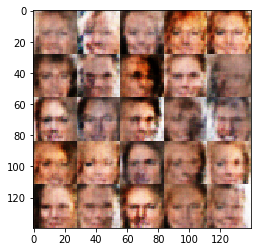

Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 2.0639
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 2.0079
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 2.2833
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 1.5292
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 1.4103
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 1.7356
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.4837
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 1.3568


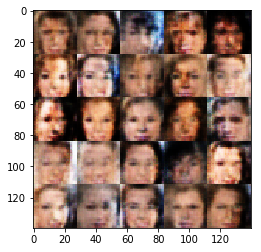

Epoch 1/1... Discriminator Loss: 0.6427... Generator Loss: 2.1690
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 1.3697
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.3487
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.1796
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 2.1952
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 1.8996
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.9109


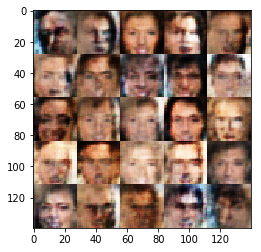

Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 3.2902
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 2.1255
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.6380
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.3074
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.4097
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 2.1846
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.2626
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 2.0128


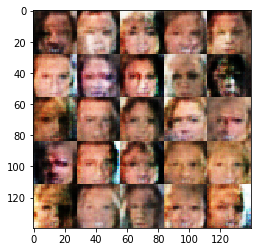

Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.4888
Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 1.9715
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 1.7840
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 1.6526
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.5921
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.3349
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.7791
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.1432


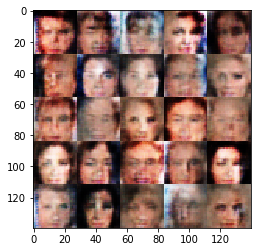

Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.8876
Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 2.0073
Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 1.7914
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 2.1667
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 2.2234
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 2.9563
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 2.0136
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 2.6755
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.4241
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.9895


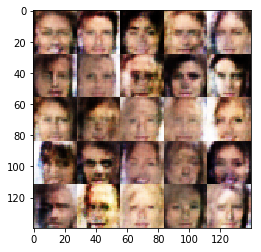

Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 1.3601
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.6991
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 1.6565
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.4583
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 2.1154
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.5833
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.4395


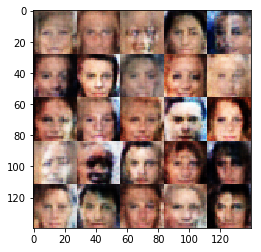

Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.4851
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 1.5064
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.7296
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.7140
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 2.9267
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.6914


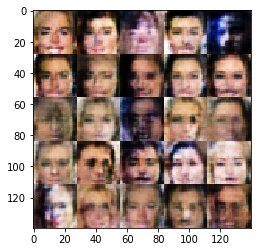

Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.7603
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 2.1126
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.7520
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 2.5771
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 1.5592
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.1808


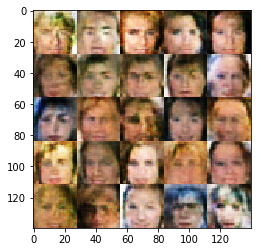

Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 2.0849
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.8042
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.5440
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.6292
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 1.9990
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 2.1326
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 1.7614
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.6452
Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 2.1624
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.2952


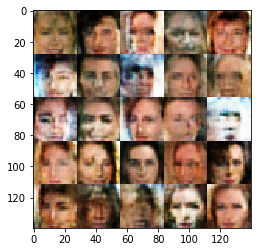

Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.3737
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 0.7370... Generator Loss: 1.6106
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 1.5687
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 2.1882
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 2.6579
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.3369
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.9596
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 2.1526


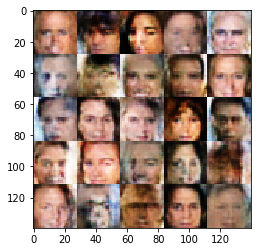

Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 1.4779
Epoch 1/1... Discriminator Loss: 0.7500... Generator Loss: 1.5307
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 2.4421
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.6765
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 1.5185
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 1.6128
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.6725


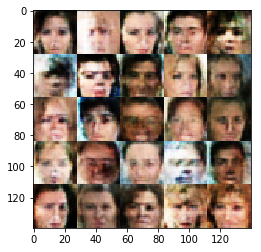

Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 2.0306
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 2.0386
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 1.3742
Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 1.7407
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.3425
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 1.4231
Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 2.2712
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 2.1359
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.1775


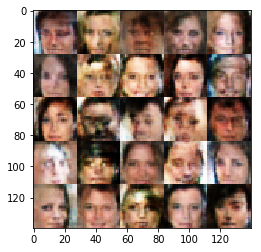

Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.3780
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 1.4274
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 1.6098
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.4931
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 2.0442
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 2.1387
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 2.0358
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 1.2735
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.6753


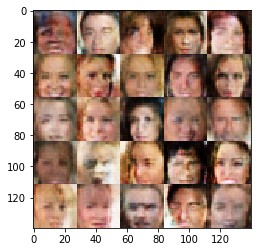

Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.2258
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 1.4815
Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 1.5471
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 1.8976
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 2.1046
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 2.3507
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 1.9877
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.2189


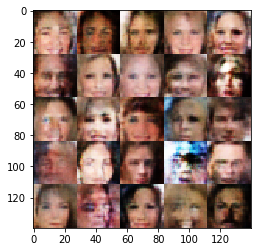

Epoch 1/1... Discriminator Loss: 0.7520... Generator Loss: 1.4086
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 2.6788
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 2.1933
Epoch 1/1... Discriminator Loss: 0.7729... Generator Loss: 1.9641
Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 1.6262
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.9826
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.4265
Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 2.1065


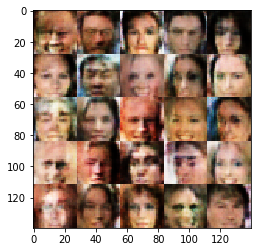

Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.3293
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.3464
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.8706
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.9304
Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 1.7610
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.8246


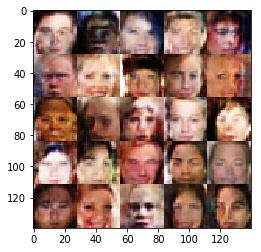

Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 2.4120
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 2.0629
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 1.8021
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 2.2067
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.4877
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 2.1913
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.6973
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.9851
Epoch 1/1... Discriminator Loss: 0.6782... Generator Loss: 1.9449


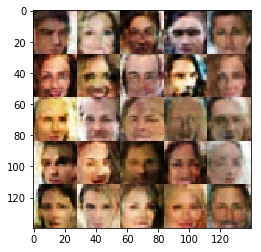

Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.8802
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 1.3824
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 2.6019
Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 1.7969
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 1.8601
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.7201
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 1.6611


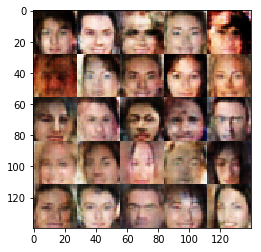

Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 1.8433
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 1.6645
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 2.8641
Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 2.0856
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 1.5977
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 2.1048
Epoch 1/1... Discriminator Loss: 0.7595... Generator Loss: 1.6629
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.5475


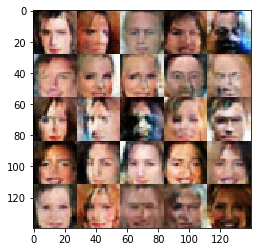

Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.3169
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.2941
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.8269
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.3944
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 1.6423
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.1516
Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 1.6824


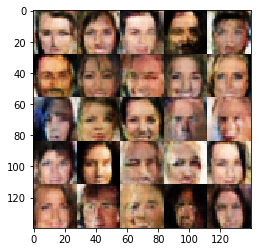

Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 2.3218
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 2.1901
Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 1.8936
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.4782
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.3359
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 1.8551
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 1.6910
Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 1.2678
Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 1.6512
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.3600


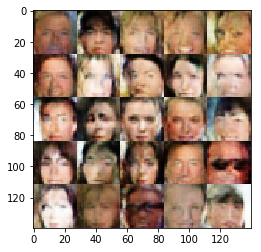

Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.4032
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 2.0308
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.5875
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 1.1683
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.0572


In [37]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.